In [9]:
%matplotlib inline
import os
import pandas as pd
from geonamescache.mappers import country
import fiona
import geopandas as gpd
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import pyplot, dates
import matplotlib.pyplot as plt
sns.set()

In [10]:
covid_path = os.path.expanduser(r'C:\Users\rgoldshmidt\Downloads\owid-covid-data.csv')
UV_path = os.path.expanduser(r'C:\Users\rgoldshmidt\Downloads\UV_1.csv')
stay_home_path = os.path.expanduser(r'C:\Users\rgoldshmidt\Downloads\stay-at-home-covid.csv')
workplace_path = os.path.expanduser(r'C:\Users\rgoldshmidt\Downloads\workplace-closures-covid.csv')

covid = pd.read_csv(covid_path)
UV = pd.read_csv(UV_path)
stay_home = pd.read_csv(stay_home_path)
workplace = pd.read_csv(workplace_path)

covid_sum = covid.groupby('iso_code').sum().reset_index()
covid_avg = covid.groupby('iso_code').mean().reset_index()


drop_list = ['COUNTRY (DISPLAY)', 'Display Value', 'COUNTRY (CODE)']
UV = UV.drop(UV.columns.difference(drop_list), axis=1)

stay_home = stay_home.groupby('Code').sum().round()['Stay at home requirements (OxBSG)'].reset_index()
stay_home['Stay at home requirements (OxBSG)']=((stay_home['Stay at home requirements (OxBSG)']-stay_home['Stay at home requirements (OxBSG)'].mean())/stay_home['Stay at home requirements (OxBSG)'].std()).round()+2

workplace = workplace.groupby('Code').sum().round()['Workplace Closures (OxBSG)'].reset_index()
workplace['Workplace Closures (OxBSG)']=((workplace['Workplace Closures (OxBSG)']-workplace['Workplace Closures (OxBSG)'].mean())/workplace['Workplace Closures (OxBSG)'].std()).round()+3

world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('+proj=robin')
world_data = world_data[world_data.name != 'Antarctica']

In [11]:
def init_world(world, workplace, stay_home, covid_sum, covid_avg):
    counts = UV.set_index('COUNTRY (CODE)')['Display Value']
    counts.name = 'UV'
    world = world.join(counts, on='iso_a3')

    counts = workplace.set_index('Code')['Workplace Closures (OxBSG)']
    counts.name = 'Workplace Closures'
    world = world.join(counts, on='iso_a3')

    counts = stay_home.set_index('Code')['Stay at home requirements (OxBSG)']
    counts.name = 'Stay at home requirements'
    world = world.join(counts, on='iso_a3')

    counts = covid_sum.set_index('iso_code')['new_deaths_per_million']
    counts.name = 'new_deaths_per_million'
    world = world.join(counts, on='iso_a3')

    counts = covid_sum.set_index('iso_code')['new_cases_per_million']
    counts.name = 'new_cases_per_million'
    world = world.join(counts, on='iso_a3')

    counts = covid_sum.set_index('iso_code')['new_cases']
    counts.name = 'new_cases'
    world = world.join(counts, on='iso_a3')

    counts = covid_sum.set_index('iso_code')['new_deaths']
    counts.name = 'new_deaths'
    world = world.join(counts, on='iso_a3')

    counts = covid_avg.set_index('iso_code')['hospital_beds_per_100k']
    counts.name = 'hospital_beds_per_100k'
    world = world.join(counts, on='iso_a3')

    counts = covid_avg.set_index('iso_code')['gdp_per_capita']
    counts.name = 'gdp_per_capita'
    world = world.join(counts, on='iso_a3')

    counts = covid_avg.set_index('iso_code')['median_age']
    counts.name = 'median_age'
    world = world.join(counts, on='iso_a3')

    counts = covid_avg.set_index('iso_code')['population']
    counts.name = 'population'
    world = world.join(counts, on='iso_a3')
    
    counts = covid_avg.set_index('iso_code')['population_density']
    counts.name = 'population_density'
    world = world.join(counts, on='iso_a3')
    
    world = world.rename({'new_deaths_per_million': 'Covid19 - deaths per million', 'new_cases_per_million': 'Covid19 - cases per million', 'new_cases': 'Covid19 - cases', 'new_deaths': 'Covid19 - deaths', 'UV': 'UV Radiation'}, axis='columns')
    
    world_text = world.copy()
    world_text['Workplace Closures'] = world_text['Workplace Closures'].replace({0:'Without Closures',\
                                                                                1: 'low Closures',\
                                                                                2: 'Partial Closures',
                                                                                3: 'Full short Closures',
                                                                                4: 'Full medium Closures',
                                                                                5: 'Full long Closures',
                                                                                6: 'Full long Closures',
                                                                                7: 'Full long Closures'})
    
    world_text['Stay at home requirements'] = world_text['Stay at home requirements'].replace({0:'Without restrictions',\
                                                                                1: 'low restrictions',\
                                                                                2: 'Partial restrictions',
                                                                                3: 'A short curfew',
                                                                                4: 'A long curfew',
                                                                                5: 'A long curfew',
                                                                                6: 'A long curfew'})
    
    world_text['population_density'] = ((world_text['population_density']-world_text['population_density'].mean())/world_text['population_density'].std()).round()+2
    world_text['population_density'] = world_text['population_density'].replace({1: 'Low',\
                                                                                2: 'Medium',\
                                                                                3: 'High',
                                                                                4: 'Very high',
                                                                                5: 'Very high',
                                                                                6: 'Very high',
                                                                                9: 'Very high'})
    world_text['UV Radiation'] = ((world_text['UV Radiation']-world_text['UV Radiation'].mean())/world_text['UV Radiation'].std()).round()+2
    world_text['UV Radiation'] = world_text['UV Radiation'].replace({0: 'Low',\
                                                                                1: 'Low',\
                                                                                2: 'Medium',
                                                                                3: 'High',
                                                                                4: 'High'})
    world_text['gdp_per_capita'] = ((world_text['gdp_per_capita']-world_text['gdp_per_capita'].mean())/world_text['gdp_per_capita'].std()).round()+2
    world_text['gdp_per_capita'] = world_text['gdp_per_capita'].replace({1: 'Low',\
                                                                                2: 'Medium',\
                                                                                3: 'High',
                                                                                4: 'Very high',
                                                                                5: 'Very high',
                                                                                6: 'Very high',
                                                                                7: 'Very high'})
    world_text['hospital_beds_per_100k'] = ((world_text['hospital_beds_per_100k']-world_text['hospital_beds_per_100k'].mean())/world_text['hospital_beds_per_100k'].std()).round()+2
    world_text['hospital_beds_per_100k'] = world_text['hospital_beds_per_100k'].replace({1: 'Low',\
                                                                                2: 'Medium',\
                                                                                3: 'High',
                                                                                4: 'Very high',
                                                                                5: 'Very high',
                                                                                6: 'Very high'})
    world_text['median_age'] = ((world_text['median_age']-world_text['median_age'].mean())/world_text['median_age'].std()).round()+2
    world_text['median_age'] = world_text['median_age'].replace({0: 'Low',\
                                                                                1: 'Medium',\
                                                                                2: 'High',
                                                                                3: 'High',
                                                                                4: 'High'})    
   
    return world, world_text

def world_map(x, y, normalize, world, folds, title1, title2):
    
    drop_list = ['geometry', x]
    map_world = world.drop(world.columns.difference(drop_list), axis=1)

    world["x"] = world['geometry'].centroid.x
    world["y"] = world['geometry'].centroid.y
    gdf = gpd.GeoDataFrame(
        map_world, geometry=gpd.points_from_xy(world.x, world.y))
    gdf['size'] = gdf[x]*normalize

    known = world.dropna(subset=[y])
    unknown = world[world[y].isna()]

    ax = known.plot(column=y, cmap='inferno_r', figsize=(20, 12), scheme='fisher_jenks', k=folds, legend=True, edgecolor='#aaaaaa')
    unknown.plot(ax=ax, color='#ffffff', hatch='//', edgecolor='#aaaaaa')

    gdf.plot(ax=ax, color='red', markersize='size')

    ax.set_title(title1, fontdict={'fontsize': 20}, loc='left')
    description = title2.strip()
    ax.annotate(description, xy=(0.07, 0.1), size=12, xycoords='figure fraction')

    ax.set_axis_off()
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((.11, .4))
    legend.prop.set_size(12)
    
def world_graph(world, x, y, type, order=None):
    known = world.dropna(subset=[x])
    if type == 'swarmplot':    
        plt.figure(figsize = (16,9))
        sns.swarmplot(x=x, y=y, hue="continent", size = 12,
                      data=known, order = order)                    
    if type == 'scatterplot':    
        plt.figure(figsize = (16,9))
        sns.scatterplot(x=x, y=y, marker='o', hue="continent", size = y, sizes=(100, 350),
                      data=known)

In [12]:
world, world_text = init_world(world_data, workplace, stay_home, covid_sum, covid_avg)

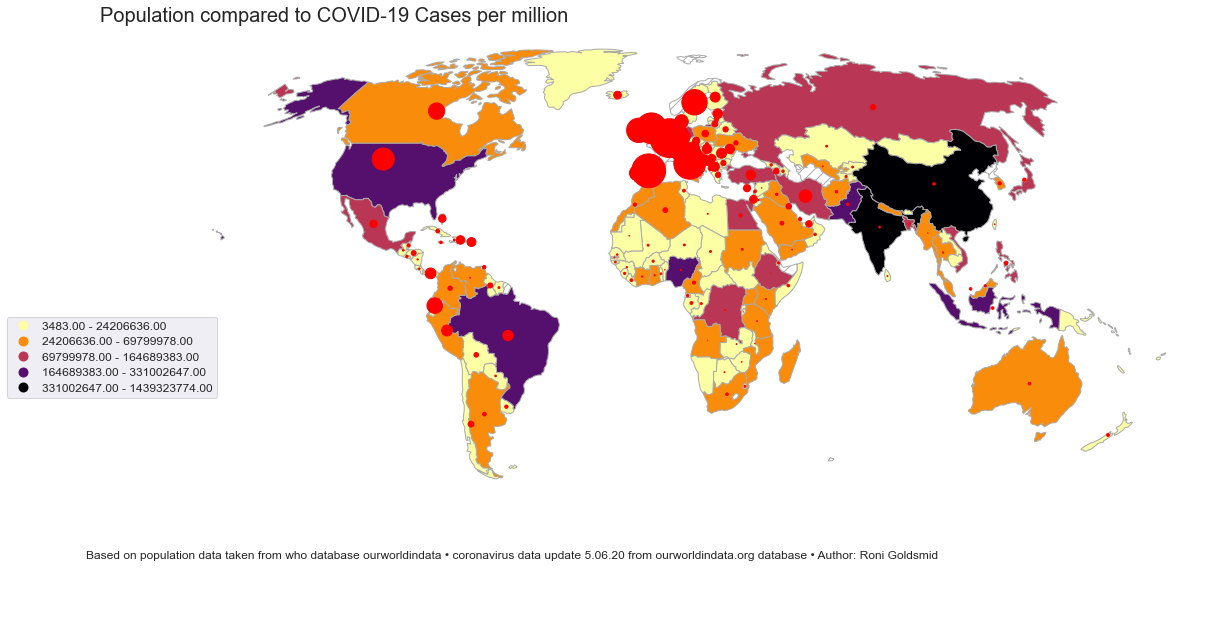

In [13]:
title1 = 'Population compared to COVID-19 Cases per million'
title2 = '''
    Based on population data taken from who database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'population',2, world, 5, title1, title2)

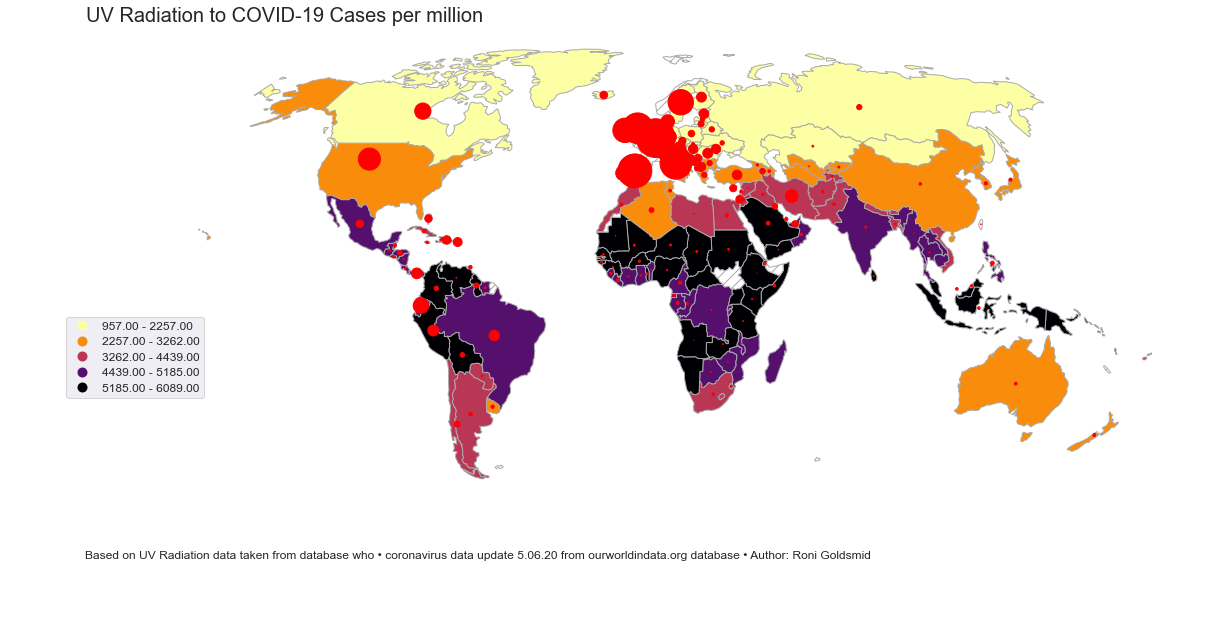

In [14]:
title1 = 'UV Radiation to COVID-19 Cases per million'
title2 = '''
    Based on UV Radiation data taken from database who • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'UV Radiation', 2, world, 5, title1, title2)

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


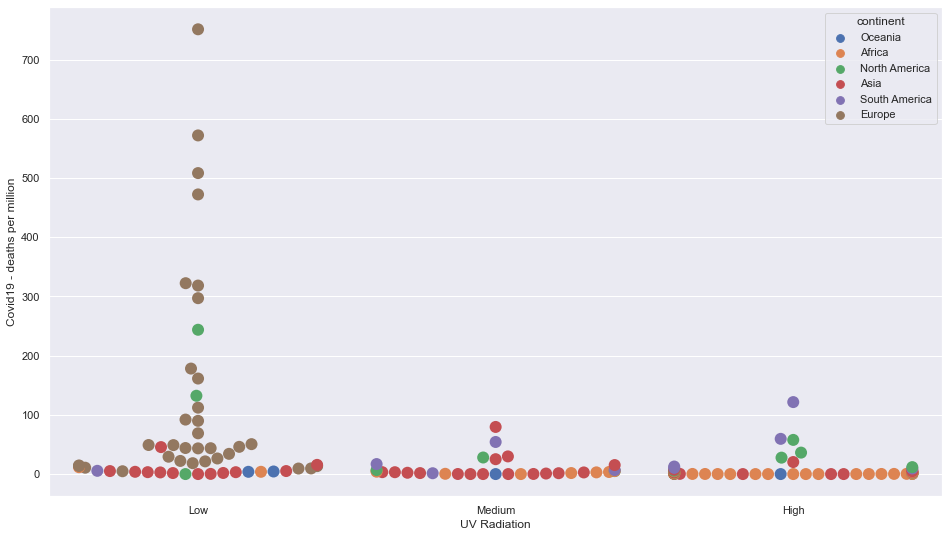

In [15]:
world_graph(world_text , 'UV Radiation', 'Covid19 - deaths per million', 'swarmplot', ['Low', 'Medium', 'High'])

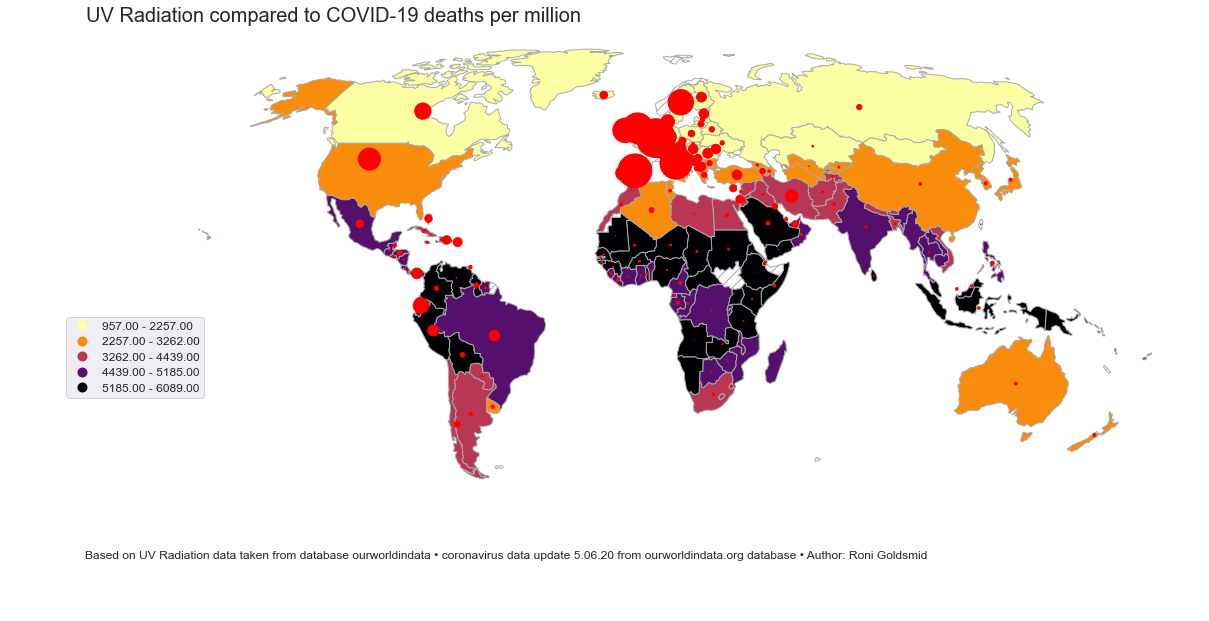

In [16]:
title1 = 'UV Radiation compared to COVID-19 deaths per million'
title2 = '''
    Based on UV Radiation data taken from database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'UV Radiation', 2, world, 5, title1, title2)

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


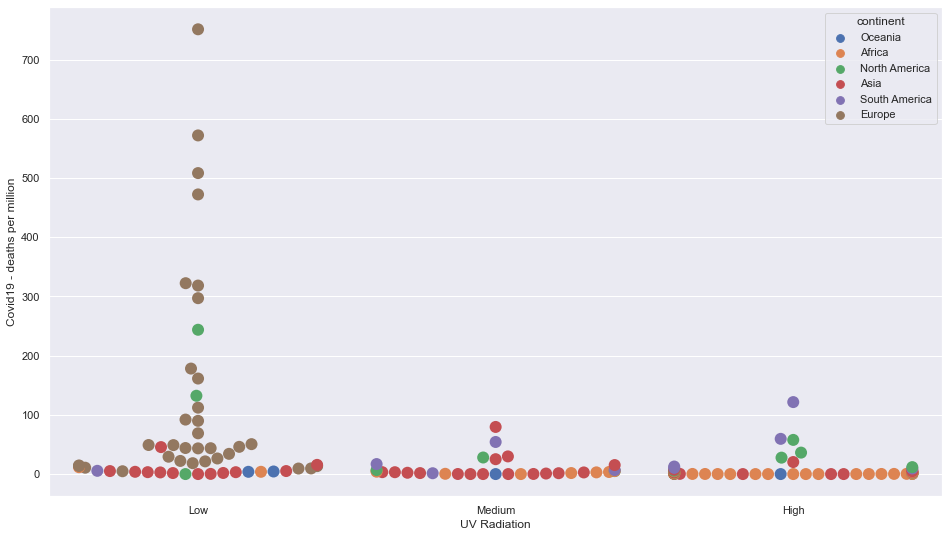

In [17]:
world_graph(world_text, 'UV Radiation', 'Covid19 - deaths per million', 'swarmplot', ['Low', 'Medium', 'High'])

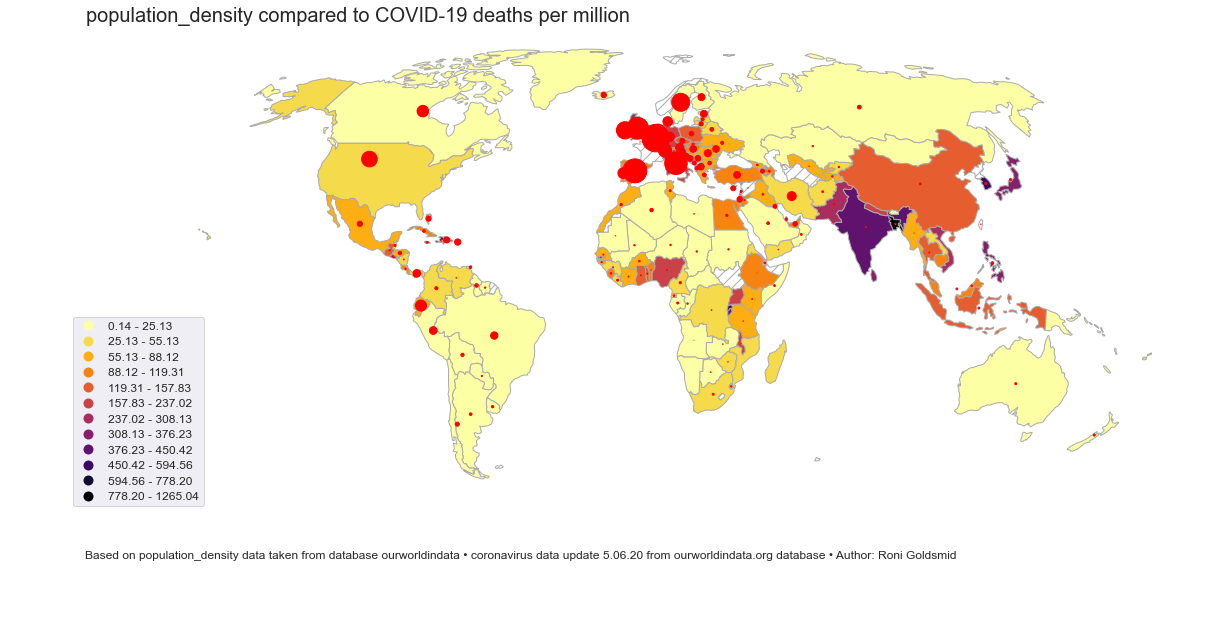

In [18]:
title1 = 'population_density compared to COVID-19 deaths per million'
title2 = '''
    Based on population_density data taken from database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'population_density', 1, world, 12, title1, title2)

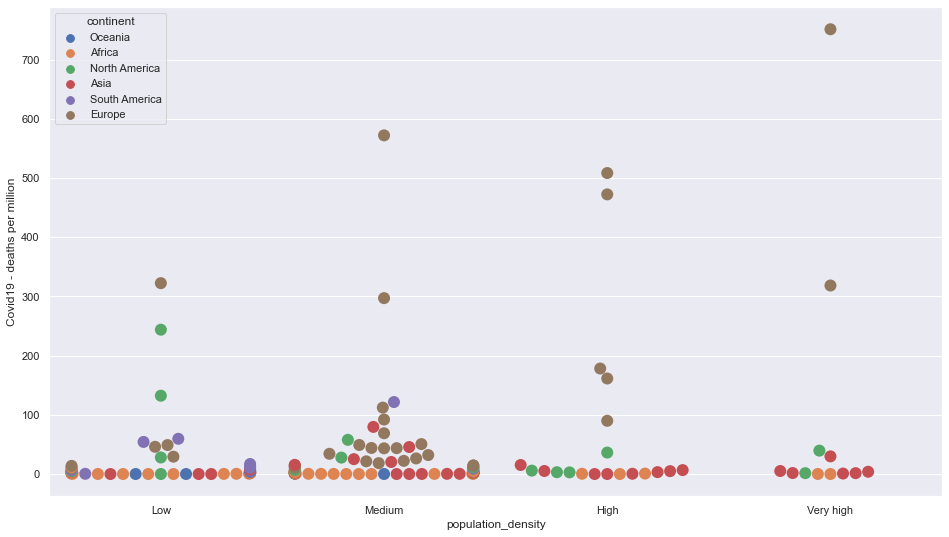

In [19]:
world_graph(world_text, 'population_density', 'Covid19 - deaths per million', 'swarmplot', ['Low', 'Medium', 'High', 'Very high'])

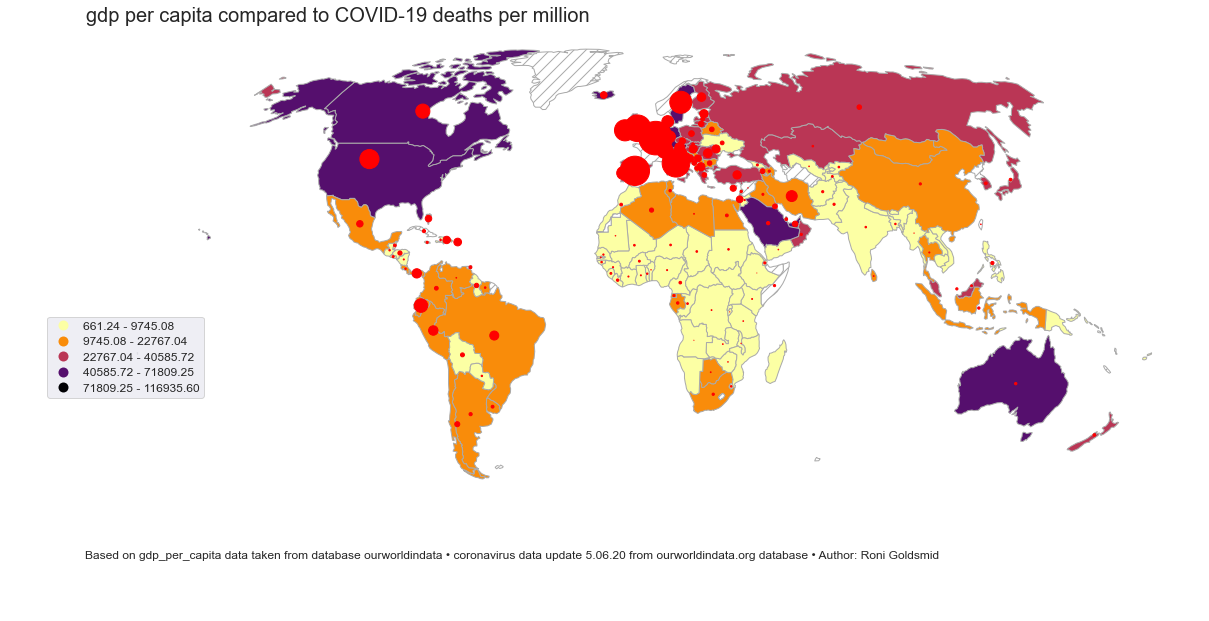

In [20]:
title1 = 'gdp per capita compared to COVID-19 deaths per million'
title2 = '''
    Based on gdp_per_capita data taken from database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'gdp_per_capita', 1.5, world, 5, title1, title2)

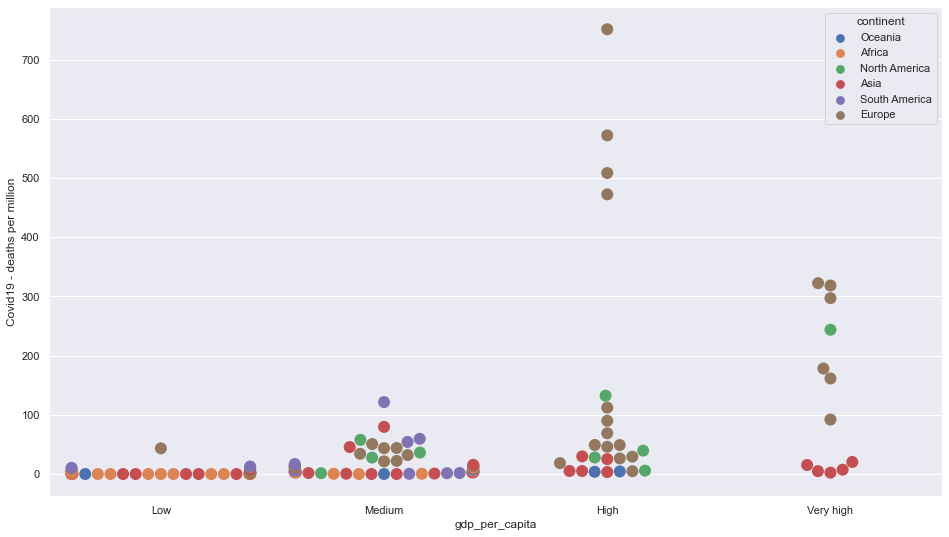

In [21]:
world_graph(world_text, 'gdp_per_capita', 'Covid19 - deaths per million', 'swarmplot',['Low', 'Medium', 'High', 'Very high'])

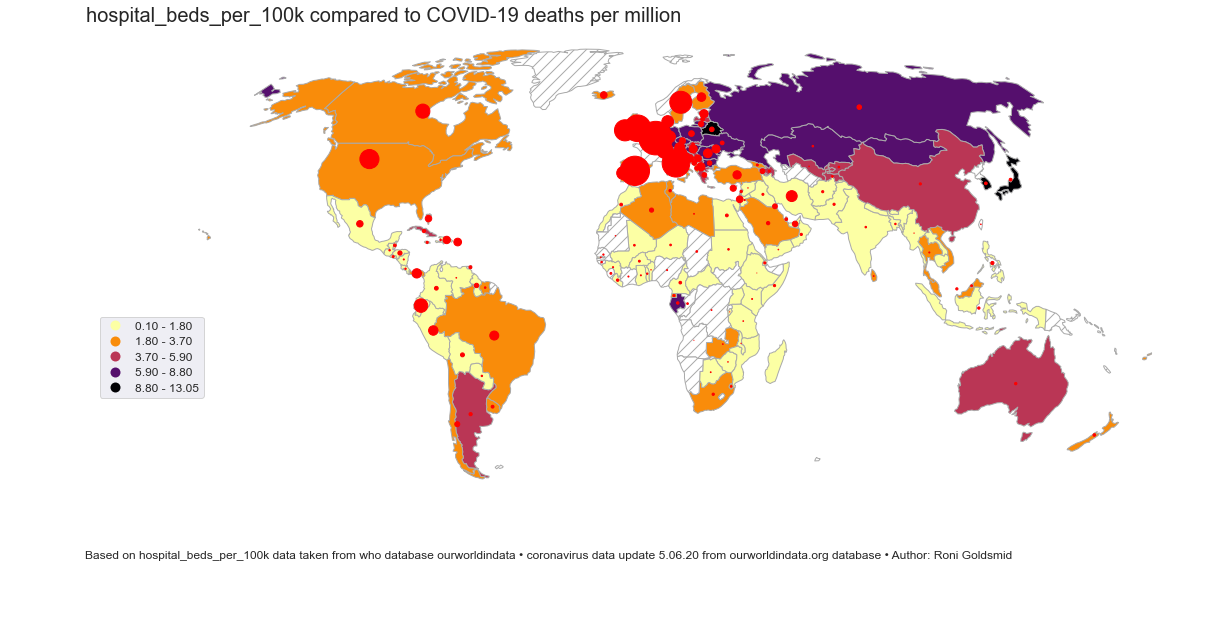

In [23]:
title1 = 'hospital_beds_per_100k compared to COVID-19 deaths per million'
title2 = '''
    Based on hospital_beds_per_100k data taken from who database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'hospital_beds_per_100k', 1.5, world, 5, title1, title2)

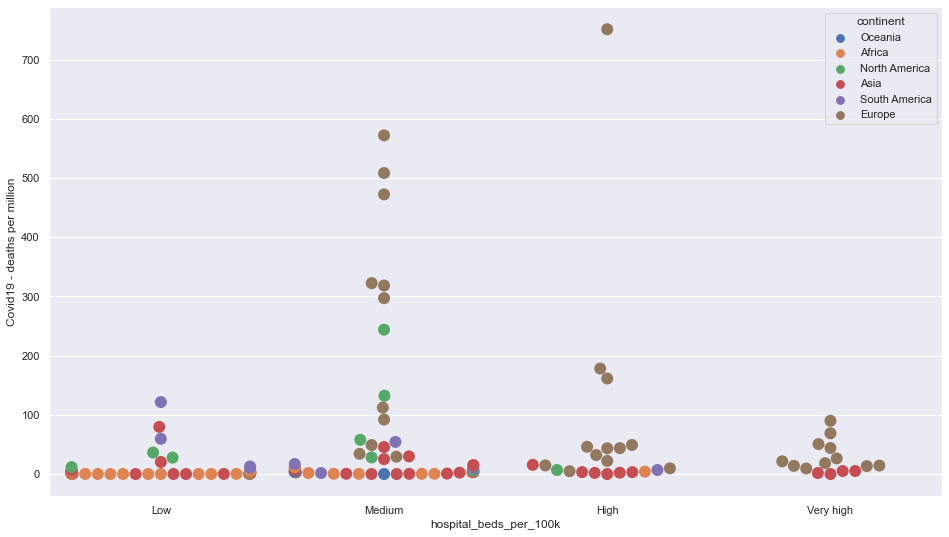

In [24]:
world_graph(world_text, 'hospital_beds_per_100k', 'Covid19 - deaths per million', 'swarmplot', ['Low', 'Medium', 'High', 'Very high'])

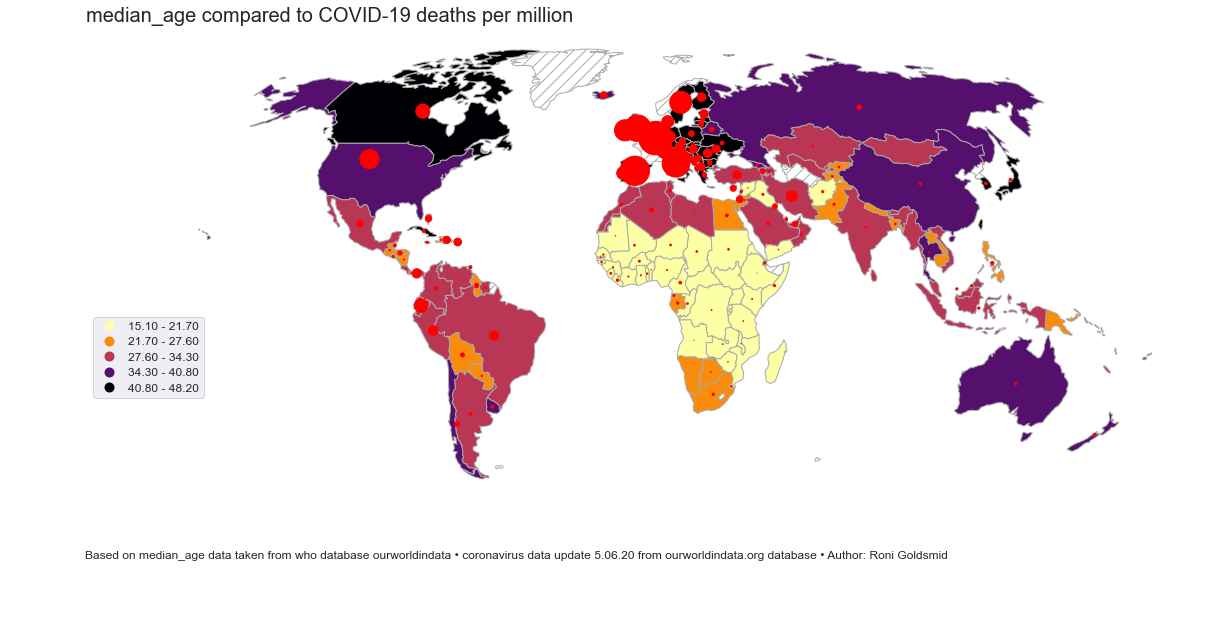

In [25]:
title1 = 'median_age compared to COVID-19 deaths per million'
title2 = '''
    Based on median_age data taken from who database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'median_age', 1.5, world, 5, title1, title2)

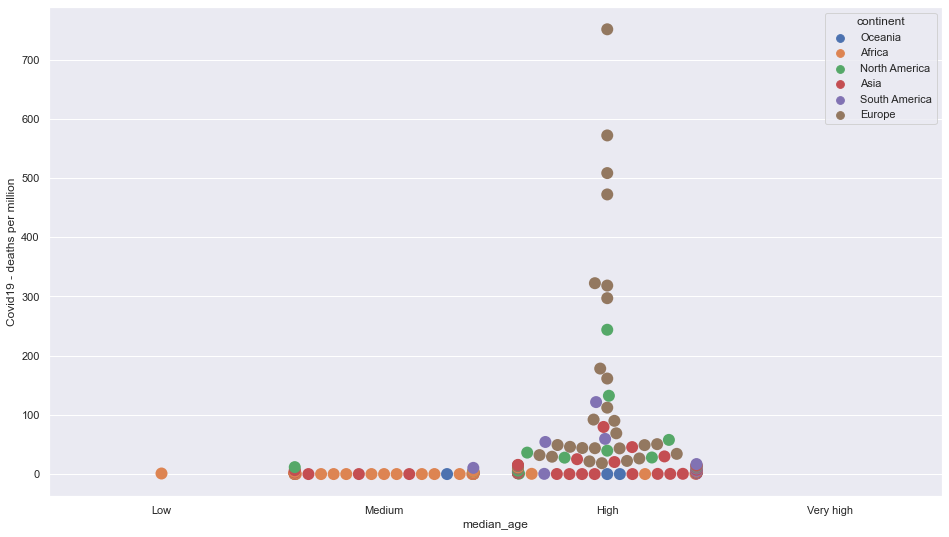

In [26]:
world_graph(world_text, 'median_age', 'Covid19 - deaths per million', 'swarmplot', ['Low', 'Medium', 'High', 'Very high'])

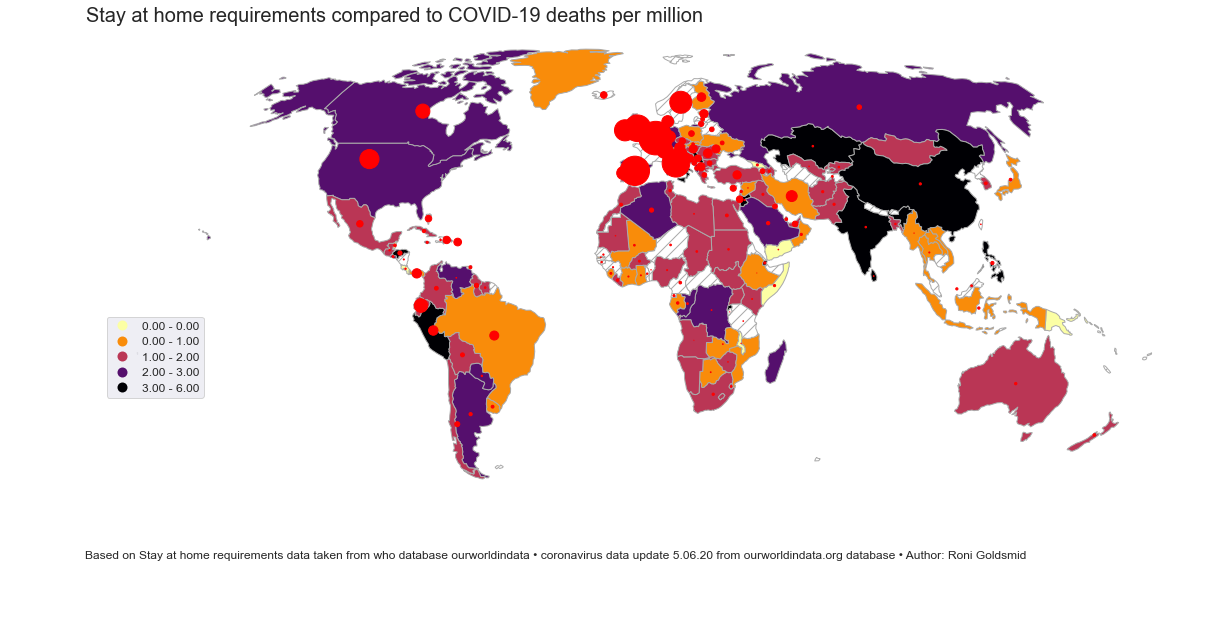

In [27]:
title1 = 'Stay at home requirements compared to COVID-19 deaths per million'
title2 = '''
    Based on Stay at home requirements data taken from who database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'Stay at home requirements', 1.5, world, 5, title1, title2)

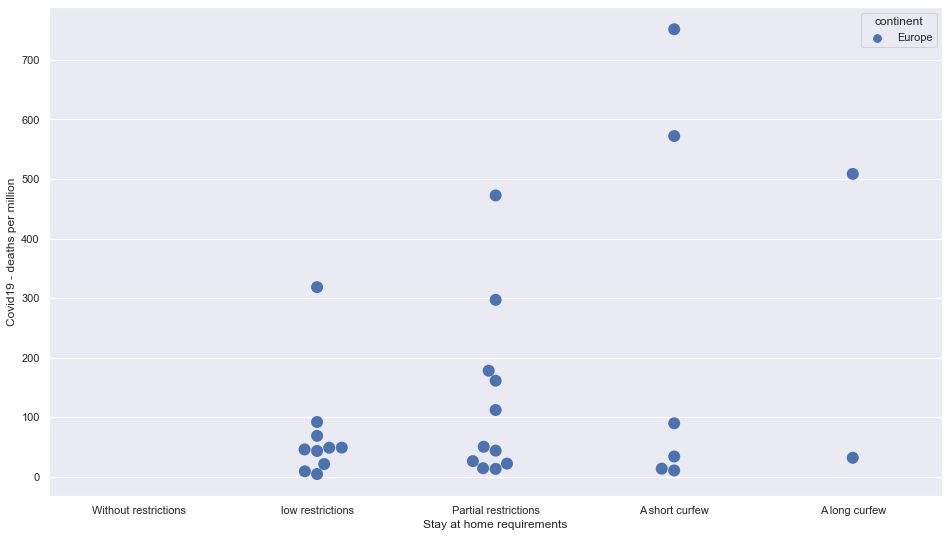

In [28]:
world_graph(world_text.loc[world_text['continent']=='Europe'], 'Stay at home requirements', 'Covid19 - deaths per million', 'swarmplot',['Without restrictions', 'low restrictions', 'Partial restrictions', 'A short curfew', 'A long curfew'])

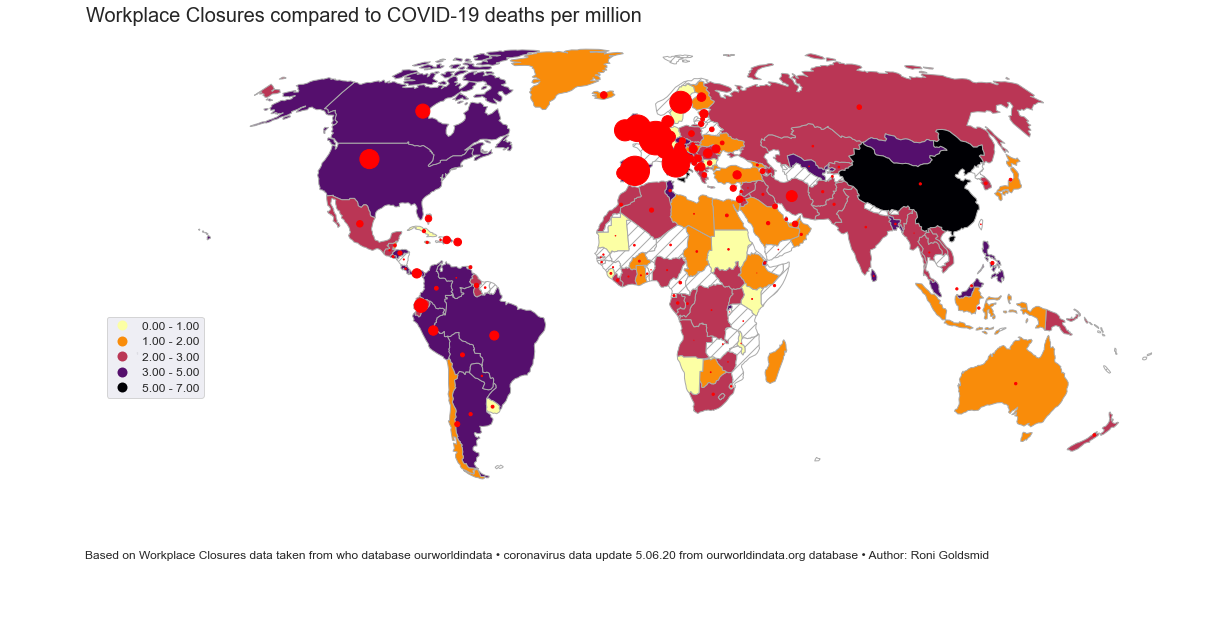

In [29]:
title1 = 'Workplace Closures compared to COVID-19 deaths per million'
title2 = '''
    Based on Workplace Closures data taken from who database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - deaths per million', 'Workplace Closures', 1.5, world, 5, title1, title2)

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


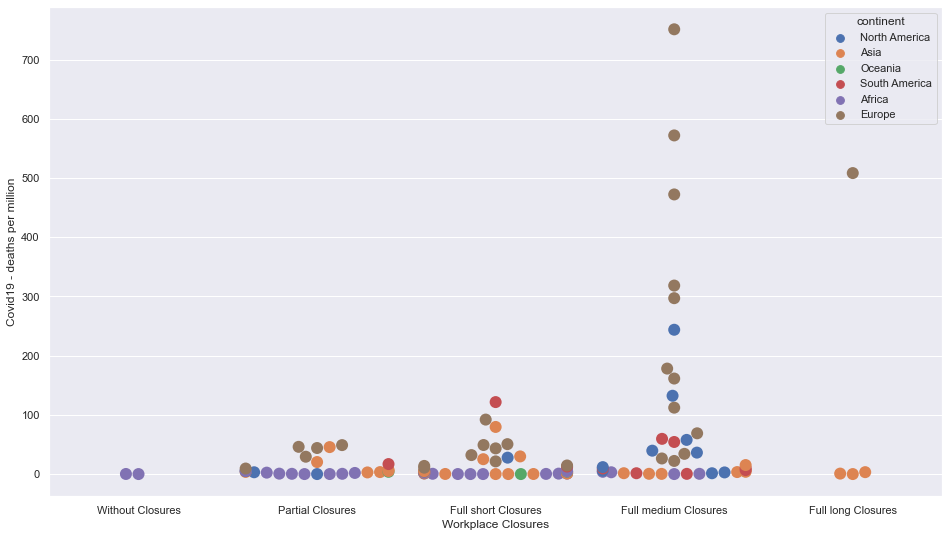

In [30]:
world_graph(world_text, 'Workplace Closures', 'Covid19 - deaths per million', 'swarmplot',['Without Closures', 'Partial Closures', 'Full short Closures', 'Full medium Closures', 'Full long Closures'])

In [31]:
world_text.loc[(world_text['Stay at home requirements']=='Partial restrictions') & (world_text['continent']=='Europe')]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,UV Radiation,Workplace Closures,Stay at home requirements,Covid19 - deaths per million,Covid19 - cases per million,Covid19 - cases,Covid19 - deaths,hospital_beds_per_100k,gdp_per_capita,median_age,population,population_density
115,9850845,Europe,Hungary,HUN,267600.0,"POLYGON ((1830455.279 5163182.144, 1879817.686...",Low,Partial Closures,Partial restrictions,43.998,342.951,3313.0,425.0,Very high,Medium,High,9660350.0,Medium
117,21529967,Europe,Romania,ROU,441000.0,"POLYGON ((2383532.998 4856386.520, 2423895.467...",Low,Full short Closures,Partial restrictions,50.533,810.286,15588.0,972.0,Very high,Medium,High,19237682.0,Medium
122,7101510,Europe,Bulgaria,BGR,143100.0,"POLYGON ((1927120.903 4724547.212, 1956300.702...",Low,low Closures,Partial restrictions,13.392,286.397,1990.0,93.0,Very high,Medium,High,6948445.0,Medium
123,10768477,Europe,Greece,GRC,290500.0,"MULTIPOLYGON (((2338608.205 3775370.890, 23302...",Low,Full short Closures,Partial restrictions,14.495,261.535,2726.0,151.0,High,Medium,High,10423056.0,Medium
126,4292095,Europe,Croatia,HRV,94240.0,"POLYGON ((1389782.132 4962882.134, 1417515.640...",Low,Full medium Closures,Partial restrictions,22.174,534.927,2196.0,91.0,High,Medium,High,4105268.0,Medium
127,8236303,Europe,Switzerland,CHE,496300.0,"POLYGON ((799805.112 5069666.510, 803938.865 5...",Low,Full medium Closures,Partial restrictions,178.173,3496.515,30261.0,1542.0,High,Very high,High,8654618.0,High
128,594130,Europe,Luxembourg,LUX,58740.0,"POLYGON ((495064.070 5340139.039, 512234.241 5...",Low,Full medium Closures,Partial restrictions,161.359,6211.103,3888.0,101.0,High,Very high,High,625976.0,High
131,10839514,Europe,Portugal,PRT,297100.0,"POLYGON ((-778863.658 4475849.638, -746532.465...",Low,Full medium Closures,Partial restrictions,112.190,2714.503,27679.0,1144.0,Medium,High,High,10196707.0,Medium
133,5011102,Europe,Ireland,IRL,322000.0,"POLYGON ((-493519.535 5723612.199, -483145.737...",Low,Full medium Closures,Partial restrictions,297.098,4685.290,23135.0,1467.0,Medium,Very high,High,4937796.0,Medium
143,64769452,Europe,United Kingdom,GBR,2788000.0,"MULTIPOLYGON (((-493519.535 5723612.199, -5527...",Low,Full medium Closures,Partial restrictions,472.334,3285.799,223060.0,32065.0,Medium,High,High,67886004.0,High


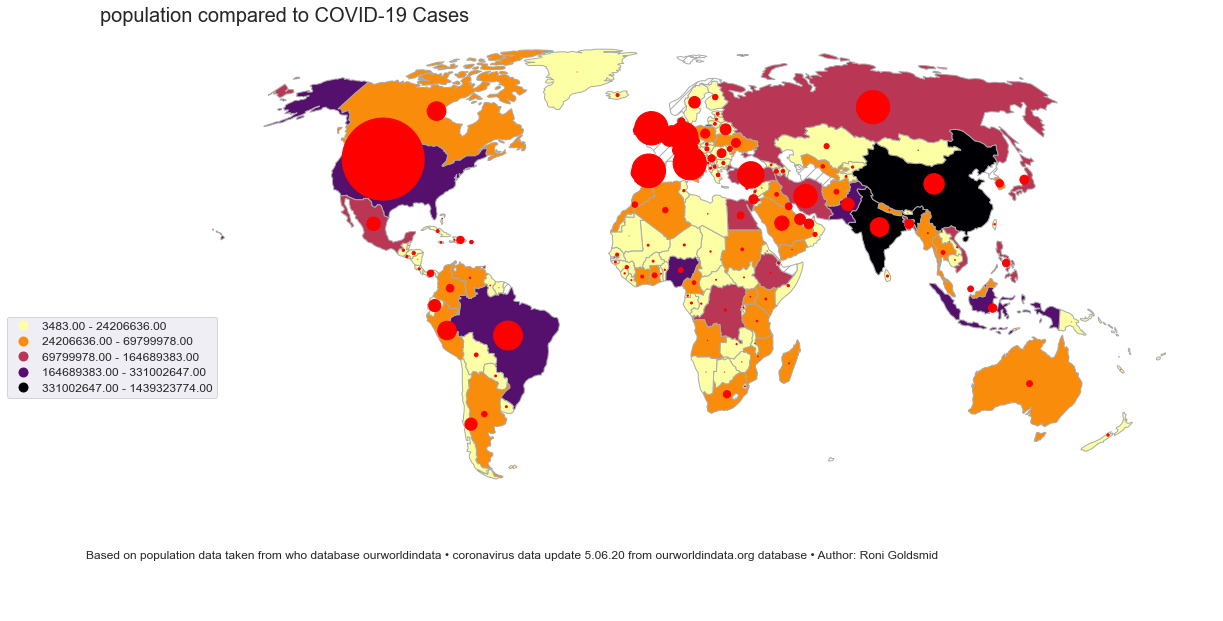

In [32]:
title1 = 'population compared to COVID-19 Cases'
title2 = '''
    Based on population data taken from who database ourworldindata • coronavirus data update 5.06.20 from ourworldindata.org database • Author: Roni Goldsmid'''
world_map('Covid19 - cases', 'population', 0.005, world, 5, title1, title2)